# Multilayer perceptron

In [1]:
import math
import pandas as pd
import numpy as np
from itertools import count
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Вспомогательные функции отрисовки представления результатов алгоритма

x - входной вектор параметров  
y - реальные значения предсказываемой величины  
pred - предсказанные значения величины

In [48]:
def PrintClfGraph(x, y, pred):
    
    plt.figure(1)
    
    for i in range(x.shape[0]):   
        clr = 'green'
        mrk = 'x'
        if (y[i] < 0.5):
            clr = 'red'
        if ((y[i] < 0.5) == (pred[i] < 0.5)):
            mrk = 'o'
        plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')

    plt.show()

clf - классификатор  
left, bottom - сдвиги по осям  
xf, yf - множитель частоты отрисовки точек  
xm, ym - количество точек по осям  
mrk - маркер

In [253]:
def PrintClfMap(clf, left=0, bottom=0, xf=2, yf=2, xm=20, ym=20, mrk='x'):
    
    x = np.array([[[i/(xf*10.0)+left, j/(yf*10.0)+bottom] for j in range(ym)] for i in range(xm)]).reshape(xm*ym, 2)
    pr = clf.predict(x)
    
    plt.figure(1)
    
    for i in range(x.shape[0]):   
        clr = 'green'
        if (pr[i] < 0.5):
            clr = 'red'
        plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')

    plt.show()

### Функция активации нейронов - сигмоида

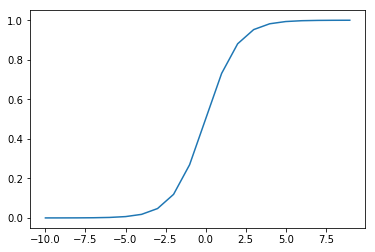

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

p = np.array([sigmoid(i) for i in range(-10, 10, 1)])
plt.plot(range(-10, 10, 1), p)
plt.show()

### Модель искусственного нейрона

In [3]:
class Neuron():
    
    ids = 0
    
    def __init__(self, dim = 1, rst = 0):
        self.dim = dim+1
        self.rst = (rst+1)*10000
        ran = np.random.RandomState(self.rst + Neuron.ids)
        self.w = (ran.random_sample(size=self.dim) - 0.5) / 2
        self.l = np.array([0.0 for _ in range(self.dim)])
        self.dw = np.array([0.0 for _ in range(self.dim)])
        self.o = 0
        Neuron.ids += 1
        
    def __del__(self):
        Neuron.ids -= 1
        
    def calc(self, x):
        x = np.append(x, -1)
        x = np.array(x)
        for i in range(x.shape[0]):
            self.l[i] = x[i]
        self.o = sigmoid(np.sum(x*self.w))
        return self.o

In [50]:
ran = np.random.RandomState(1)
data = ran.randint(low=1, high=100, size=5).reshape(1, -1) + 0.0
print "input =", data
x = normalize(data)[0]
print "i =", x
n = Neuron(dim=x.shape[0], rst=0)
print "w =", n.w
print "f =", n.calc(x)
print "o =", n.o
print "l =", n.l

input = [[ 38.  13.  73.  10.  76.]]
i = [ 0.33563981  0.11482414  0.64478173  0.08832627  0.67127961]
w = [-0.17987567  0.09917159  0.17750526 -0.01472293 -0.19730512 -0.185235  ]
f = 0.529205139146
o = 0.529205139146
l = [ 0.33563981  0.11482414  0.64478173  0.08832627  0.67127961 -1.        ]


### Тестовый набор данных (размеченны вручную)

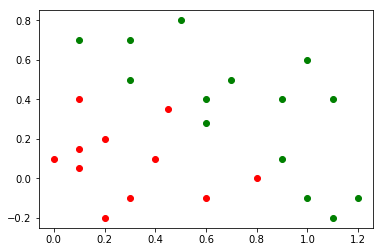

In [41]:
M = np.array([[0, 1], 
              [1, 1.5], 
              [1, 0.5], 
              [6, 2.8], 
              [4, 1], 
              [5, 8], 
              [6, 4], 
              [7, 5], 
              [3, 7], 
              [2, 2], 
              [1, 4], 
              [3, 5], 
              [4.5, 3.5],
              [9, 1],
              [12, -1],
              [10, -1],
              [10, 6],
              [8, 0],
              [11, 4],
              [11, -2],
              [6, -1],
              [2, -2],
              [3, -1],
              [9, 4],
              [1, 7]])

N = np.array([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1])

M = M / 10

plt.figure(1)
for i in range(M.shape[0]):
    clr = 'green'
    if (N[i] == -1 or N[i] == 0):
        clr = 'red'
    plt.plot(M[i][0], M[i][1], marker='o', color=clr, ls='')
plt.show()

In [60]:
class MLP_2():
    
    def __init__(self, dim = 1, learning_rate = 1, alpha = 0, max_iter=100, rst = 0, print_w = False):
        self.dim = dim
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.max_iter = max_iter
        self.rst = rst
        self.n = np.array([None for _ in range(2)])
        self.n[0] = [Neuron(dim=dim, rst=rst), Neuron(dim=dim, rst=rst)]
        self.n[1] = [Neuron(dim=2, rst=rst)]
        
    def fit(self, x, y):
        for kit in range(self.max_iter):
            for xi, yi in zip(x, y):
                lr = self.learning_rate
                out = xi
                for l in range(self.n.shape[0]):
                    out = np.array([self.n[l][k].calc(out) for k in range(len(self.n[l]))])
                # Для последнего слоя:
                delta6 = (yi - self.n[1][0].o) * ((1 - self.n[1][0].o) * self.n[1][0].o)
                # Для предпоследнего слоя:
                delta4 = ((1 - self.n[0][0].o) * self.n[0][0].o) * (self.n[1][0].w[0] * delta6)
                delta5 = ((1 - self.n[0][1].o) * self.n[0][1].o) * (self.n[1][0].w[1] * delta6)
                # Меняем коэф. на последнем слое
                for i in range(len(self.n[0])):
                    self.n[1][0].dw[i] = lr * delta6 * self.n[1][0].l[i] + self.alpha * self.n[1][0].dw[i]
                    self.n[1][0].w[i] += self.n[1][0].dw[i]
                # Меняем коэф. на предпоследнем слое
                for i in range(self.dim):
                    self.n[0][0].dw[i] = lr * delta4 * self.n[0][0].l[i] + self.alpha * self.n[0][0].dw[i]
                    self.n[0][0].w[i] += self.n[0][0].dw[i]
                    self.n[0][1].dw[i] = lr * delta5 * self.n[0][1].l[i] + self.alpha * self.n[0][1].dw[i]
                    self.n[0][1].w[i] += self.n[0][1].dw[i]   
        return self
    
    def predict(self, x):
        res = []
        for xi in x:
            inp = xi
            for l in range(self.n.shape[0]):
                inp = np.array([self.n[l][k].calc(inp) for k in range(len(self.n[l]))])
            res.append(inp[0])
        return np.array(res)

### Применение многослойного персептрона (2 слоя) для задачи классификации

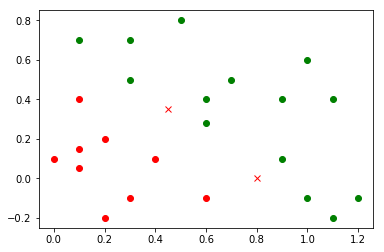

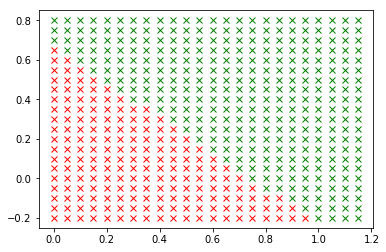

In [263]:
NN = None
NN = MLP_2(dim=2, learning_rate=0.4, alpha=0.1, max_iter=2000, rst=1)
NN.fit(M, N)
pr = NN.predict(M)
PrintClfGraph(M, N, pr)
PrintClfMap(NN, left=0, bottom=-0.2, xf=2, yf=2, xm=24, ym=21)

In [64]:
class MLP():
    
    def __init__(self, dim = 1, learning_rate = 1, alpha = 0, max_iter = 100, rst = 0, print_w = False):
        self.dim = dim
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.max_iter = max_iter
        self.rst = rst
        self.n = np.array([None for _ in range(3)])
        self.n[0] = [Neuron(dim=dim, rst=rst), Neuron(dim=dim, rst=rst), Neuron(dim=dim, rst=rst)]
        self.n[1] = [Neuron(dim=len(self.n[0]), rst=rst), Neuron(dim=len(self.n[0]), rst=rst)]
        self.n[2] = [Neuron(dim=len(self.n[1]), rst=rst)]
        if (print_w):
            print self.n[0][0].w
            print self.n[0][1].w
            print self.n[0][2].w
            print self.n[1][0].w
            print self.n[1][1].w
            print self.n[2][0].w
        
    def fit(self, x, y):
        for iteration in range(self.max_iter):
            for xi, yi in zip(x, y):
                lr = self.learning_rate
                out = xi
                for l in range(self.n.shape[0]):
                    out = np.array([self.n[l][k].calc(out) for k in range(len(self.n[l]))])
                # Для последнего слоя:
                delta6 = (yi - self.n[2][0].o) * ((1 - self.n[2][0].o) * self.n[2][0].o)
                # Для предпоследнего слоя:
                delta4 = ((1 - self.n[1][0].o) * self.n[1][0].o) * (self.n[2][0].w[0] * delta6)
                delta5 = ((1 - self.n[1][1].o) * self.n[1][1].o) * (self.n[2][0].w[1] * delta6)
                # Для первого слоя (пред-предпоследнего):
                delta1 = ((1 - self.n[0][0].o) * self.n[0][0].o) * (self.n[1][0].w[0] * delta4 + self.n[1][1].w[0] * delta5)
                delta2 = ((1 - self.n[0][1].o) * self.n[0][1].o) * (self.n[1][0].w[1] * delta4 + self.n[1][1].w[1] * delta5)
                delta3 = ((1 - self.n[0][2].o) * self.n[0][2].o) * (self.n[1][0].w[2] * delta4 + self.n[1][1].w[2] * delta5)
                # Меняем коэф. на первом слое (пред-предпоследнем)
                for i in range(self.dim+1):
                    self.n[0][0].dw[i] = lr * delta1 * self.n[0][0].l[i] + self.alpha * self.n[0][0].dw[i]
                    self.n[0][0].w[i] += self.n[0][0].dw[i]
                    self.n[0][1].dw[i] = lr * delta2 * self.n[0][1].l[i] + self.alpha * self.n[0][1].dw[i]
                    self.n[0][1].w[i] += self.n[0][1].dw[i]
                    self.n[0][2].dw[i] = lr * delta3 * self.n[0][2].l[i] + self.alpha * self.n[0][2].dw[i]
                    self.n[0][2].w[i] += self.n[0][2].dw[i]
                # Меняем коэф. на предпоследнем слое
                for i in range(len(self.n[0])+1):
                    self.n[1][0].dw[i] = lr * delta4 * self.n[1][0].l[i] + self.alpha * self.n[1][0].dw[i]
                    self.n[1][0].w[i] += self.n[1][0].dw[i]
                    self.n[1][1].dw[i] = lr * delta5 * self.n[1][1].l[i] + self.alpha * self.n[1][1].dw[i]
                    self.n[1][1].w[i] += self.n[1][1].dw[i]
                # Меняем коэф. на последнем слое (с индексом 2)
                for i in range(len(self.n[1])+1):
                    self.n[2][0].dw[i] = lr * delta6 * self.n[2][0].l[i] + self.alpha * self.n[2][0].dw[i]
                    self.n[2][0].w[i] += self.n[2][0].dw[i]
                
        return self
    
    def predict(self, x):
        res = []
        for xi in x:
            inp = xi
            for l in range(self.n.shape[0]):
                inp = np.array([self.n[l][k].calc(inp) for k in range(len(self.n[l]))])
            res.append(inp[0])
        return res

### Применение многослойного персептрона (3 слоя) для задачи классификации

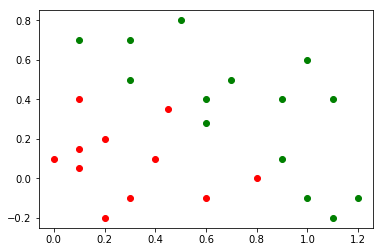

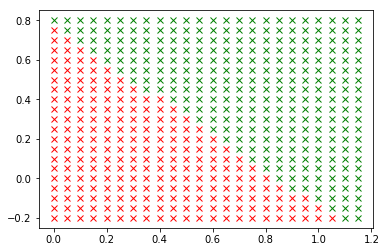

In [262]:
NN = None
NN = MLP(dim=2, learning_rate=0.4, alpha=0.1, max_iter=2000, rst=1)
NN.fit(M, N)
pr = NN.predict(M)
PrintClfGraph(M, N, pr)
PrintClfMap(NN, left=0, bottom=-0.2, xf=2, yf=2, xm=24, ym=21)

### Многослойный персептрон на больших данных

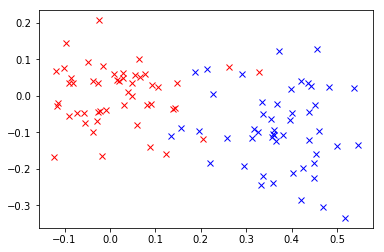

In [265]:
rst = np.random.RandomState(2)
a = rst.normal(-10, 10, 100)
a = a.reshape(50, 2)
a[:, 0] = a[:, 0]+50
b = rst.normal(0, 8, 100)
b = b.reshape(50, 2)
x = np.concatenate((a, b), axis=0)
y = np.array([i/50 for i in range(100)])
x = x / 100
for i in range(100):
    mrk = 'x'
    clr = 'red'
    if (y[i] < 0.5):
        clr = 'blue'
    plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')
plt.show()

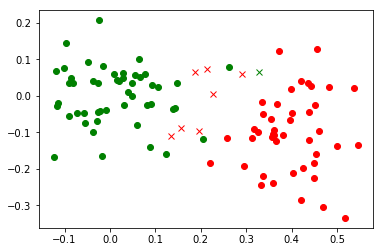

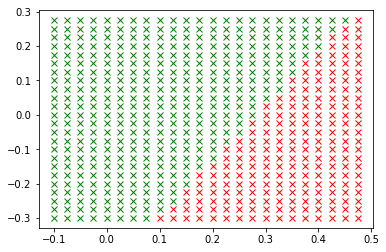

In [275]:
NN = None
NN = MLP(dim=2, learning_rate=0.8, alpha=0.3, max_iter=600, rst=1)
NN.fit(x, y)
pr = NN.predict(x)
PrintClfGraph(x, y, pr)
PrintClfMap(NN, left=-0.1, bottom=-0.3, xf=4, yf=4, xm=24, ym=24)

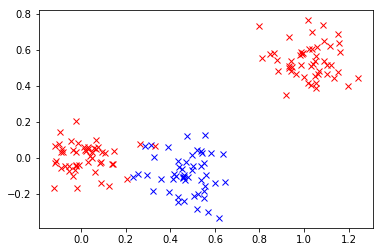

In [276]:
rst = np.random.RandomState(2)
a = rst.normal(-10, 10, 100)
a = a.reshape(50, 2)
a[:, 0] = a[:, 0]+60
b = rst.normal(0, 8, 100)
b = b.reshape(50, 2)
c = rst.normal(-10, 10, 100)
c = c.reshape(50, 2)
c = c + 65
c[:, 0] = c[:, 0]+50
x = np.concatenate((a, b, c), axis=0)
y = np.array([i/50 for i in range(150)])
x = x / 100
for i in range(150):
    mrk = 'x'
    clr = 'red'
    if (y[i] < 0.5):
        clr = 'blue'
    plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')
plt.show()

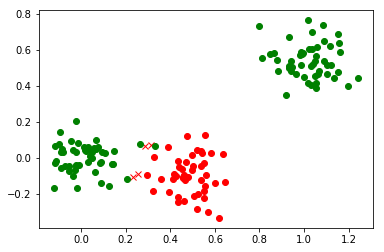

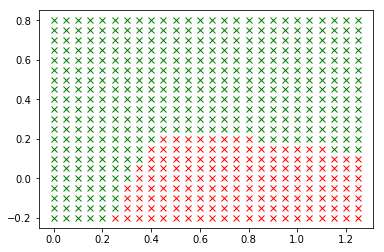

In [278]:
NN = None
NN = MLP(dim=2, learning_rate=0.8, alpha=0.5, max_iter=1000, rst=1)
NN.fit(x, y)
pr = NN.predict(x)
PrintClfGraph(x, y, pr)
PrintClfMap(NN, left=0, bottom=-0.2, xf=2, yf=2, xm=26, ym=21)

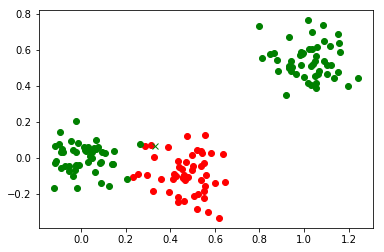

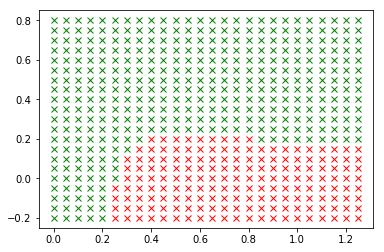

In [279]:
NN = None
NN = MLP(dim=2, learning_rate=0.5, alpha=0.3, max_iter=2000, rst=1)
NN.fit(x, y)
pr = NN.predict(x)
PrintClfGraph(x, y, pr)
PrintClfMap(NN, left=0, bottom=-0.2, xf=2, yf=2, xm=26, ym=21)

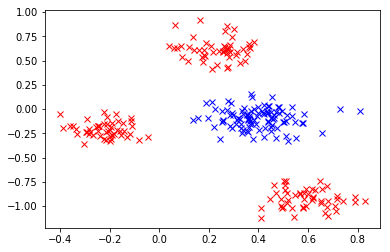

In [280]:
rst = np.random.RandomState(2)
a = rst.normal(-10, 10, 200)
a = a.reshape(100, 2)
a[:, 0] = a[:, 0]+50
b = rst.normal(0, 8, 100)
b = b.reshape(50, 2)-20
c = rst.normal(-10, 10, 100)
c = c.reshape(50, 2) + 70
c[:, 0] = c[:, 0]-40
d = rst.normal(-10, 10, 100)
d = d.reshape(50, 2) - 80
d[:, 0] = d[:, 0]+150
x = np.concatenate((a, b, c, d), axis=0)
y = np.array([i/100 for i in range(250)])
x = x / 100
for i in range(250):
    mrk = 'x'
    clr = 'red'
    if (y[i] < 0.5):
        clr = 'blue'
    plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')
plt.show()

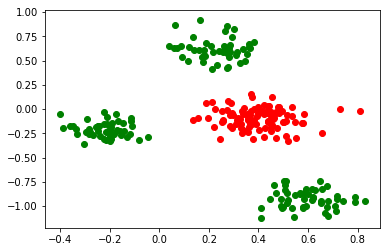

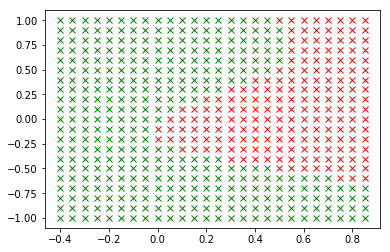

In [281]:
NN = None
NN = MLP(dim=2, learning_rate=0.8, alpha=0.5, max_iter=300, rst=1)
NN.fit(x, y)
pr = NN.predict(x)
PrintClfGraph(x, y, pr)
PrintClfMap(NN, left=-0.4, bottom=-1.0, xf=2, yf=1, xm=26, ym=21)

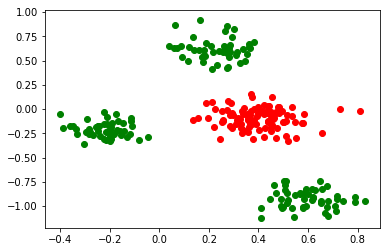

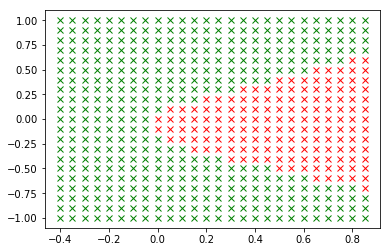

In [286]:
NN = None
NN = MLP(dim=2, learning_rate=0.4, alpha=0.3, max_iter=2000, rst=1)
NN.fit(x, y)
pr = NN.predict(x)
PrintClfGraph(x, y, pr)
PrintClfMap(NN, left=-0.4, bottom=-1.0, xf=2, yf=1, xm=26, ym=21)

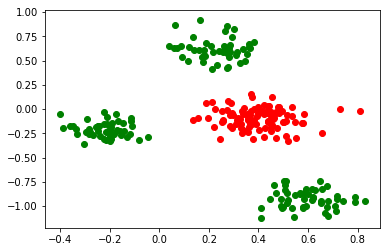

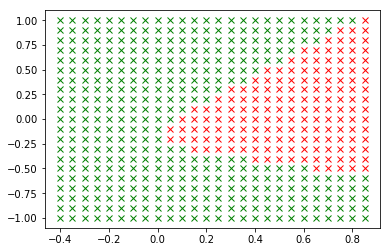

In [287]:
NN = None
NN = MLP_2(dim=2, learning_rate=0.4, alpha=0.3, max_iter=2000, rst=1)
NN.fit(x, y)
pr = NN.predict(x)
PrintClfGraph(x, y, pr)
PrintClfMap(NN, left=-0.4, bottom=-1.0, xf=2, yf=1, xm=26, ym=21)

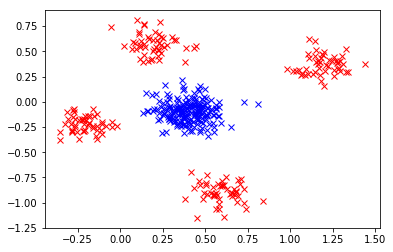

In [300]:
rst = np.random.RandomState(2)
a = rst.normal(-10, 10, 400)
a = a.reshape(200, 2)
a[:, 0] = a[:, 0]+50
b = rst.normal(0, 8, 100)
b = b.reshape(50, 2)-20
c = rst.normal(-10, 10, 100)
c = c.reshape(50, 2) + 70
c[:, 0] = c[:, 0]-40
d = rst.normal(-10, 10, 100)
d = d.reshape(50, 2) - 80
d[:, 0] = d[:, 0]+150
e = rst.normal(-10, 10, 100)
e = e.reshape(50, 2) + 50
e[:, 0] = d[:, 0]+60
x = np.concatenate((a, b, c, d, e), axis=0)
y = np.array([i/200 for i in range(400)])
x = x / 100
for i in range(400):
    mrk = 'x'
    clr = 'red'
    if (y[i] < 0.5):
        clr = 'blue'
    plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')
plt.show()

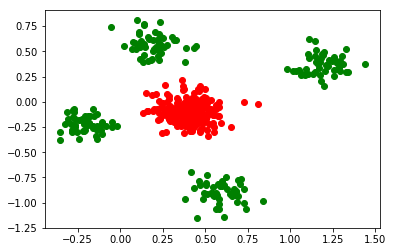

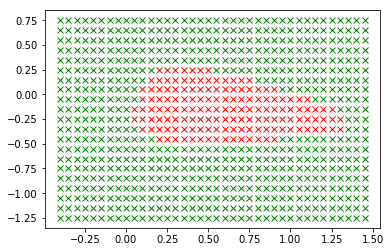

In [312]:
NN = None
NN = MLP(dim=2, learning_rate=0.4, alpha=0.1, max_iter=1000, rst=1)
NN.fit(x, y)
pr = NN.predict(x)
PrintClfGraph(x, y, pr)
PrintClfMap(NN, left=-0.4, bottom=-1.25, xf=2, yf=1, xm=38, ym=21)

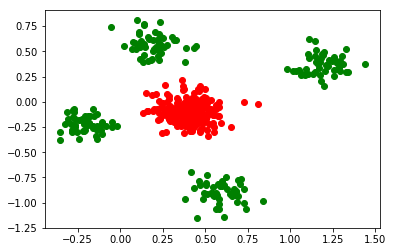

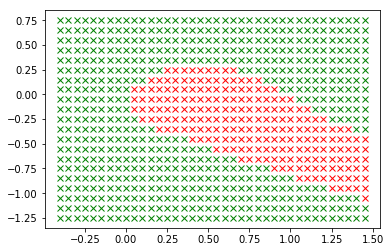

In [313]:
NN = None
NN = MLP(dim=2, learning_rate=0.4, alpha=0.5, max_iter=1000, rst=1)
NN.fit(x, y)
pr = NN.predict(x)
PrintClfGraph(x, y, pr)
PrintClfMap(NN, left=-0.4, bottom=-1.25, xf=2, yf=1, xm=38, ym=21)